In [293]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
QUANDL_KEY = '2jxLk6YXWX8G9cKw-qCs'
quandl.ApiConfig.api_key = QUANDL_KEY
import pandas_datareader.data as web
import datetime
%matplotlib inline

In [294]:
start = datetime.datetime(2002, 1, 1)
end = datetime.datetime(2020, 4, 1)
df_quandl = web.DataReader('AAPL', 'yahoo', start, end)


In [295]:
df = df_quandl.loc[:,['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)
df

,adj_close
Date,
2002-01-02,1.444668
2002-01-03,1.462029
2002-01-04,1.468849
2002-01-07,1.419867
2002-01-08,1.401886
...,...
2020-03-26,258.440002
2020-03-27,247.740005
2020-03-30,254.809998


In [296]:
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn']=np.log(df.adj_close/df.adj_close.shift(1))
df

,adj_close,simple_rtn,log_rtn
Date,,,
2002-01-02,1.444668,NaN,NaN
2002-01-03,1.462029,0.012017,0.011946
2002-01-04,1.468849,0.004665,0.004654
2002-01-07,1.419867,-0.033347,-0.033916
2002-01-08,1.401886,-0.012664,-0.012744
...,...,...,...
2020-03-26,258.440002,0.052623,0.051285
2020-03-27,247.740005,-0.041402,-0.042284
2020-03-30,254.809998,0.028538,0.028138


In [297]:
df_all_dates = pd.DataFrame(index=pd.date_range(start='2002-01-01', end= '2020-04-01'))
df_merged=df
df_merged= df_all_dates.join(df[['adj_close', 'simple_rtn', 'log_rtn']], how='left').fillna(method='ffill').asfreq('M')
# merged with index data, frequency = M

In [298]:
df_cpi = quandl.get(dataset='RATEINF/CPI_USA', start_date = '2002-01-01', end_date= '2020-04-03')
df_cpi.rename(columns={'Value' : 'cpi'}, inplace=True)

In [299]:
# merge inflation data to prices
df_merged=df_merged.join(df_cpi, how='left')

In [300]:
df_merged['inflation_rate'] = df_merged.cpi.pct_change()

In [301]:
# adjust for real return
df_merged['real_rtn']= (df_merged.simple_rtn + 1) / (df_merged.inflation_rate + 1 ) - 1
df_merged

,adj_close,simple_rtn,log_rtn,cpi,inflation_rate,real_rtn
2002-01-31,1.532712,0.026152,0.025816,177.100,NaN,NaN
2002-02-28,1.345463,-0.011840,-0.011911,177.800,0.003953,-0.015731
2002-03-31,1.467609,0.008522,0.008486,178.800,0.005624,0.002881
2002-04-30,1.504811,0.012938,0.012855,179.800,0.005593,0.007305
2002-05-31,1.444668,-0.037191,-0.037900,179.800,0.000000,-0.037191
...,...,...,...,...,...,...
2019-11-30,266.617249,-0.002203,-0.002205,257.208,-0.000536,-0.001667
2019-12-31,292.954712,0.007306,0.007280,256.974,-0.000910,0.008224
2020-01-31,308.777191,-0.044339,-0.045352,257.971,0.003880,-0.048032
2020-02-29,273.359985,-0.000585,-0.000585,258.678,0.002741,-0.003317


In [302]:
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

In [303]:
# calculate monthly realized volatility
df_merged['realized_vol'] = df_merged['log_rtn'].apply(realized_volatility)
df_merged['realized_vol']

2002-01-31    0.025816
2002-02-28    0.011911
2002-03-31    0.008486
2002-04-30    0.012855
2002-05-31    0.037900
                ...   
2019-11-30    0.002205
2019-12-31    0.007280
2020-01-31    0.045352
2020-02-29    0.000585
2020-03-31    0.002043
Freq: M, Name: realized_vol, Length: 219, dtype: float64

In [304]:
df_merged['realized_vol']=df_merged['realized_vol'] * np.sqrt(12)

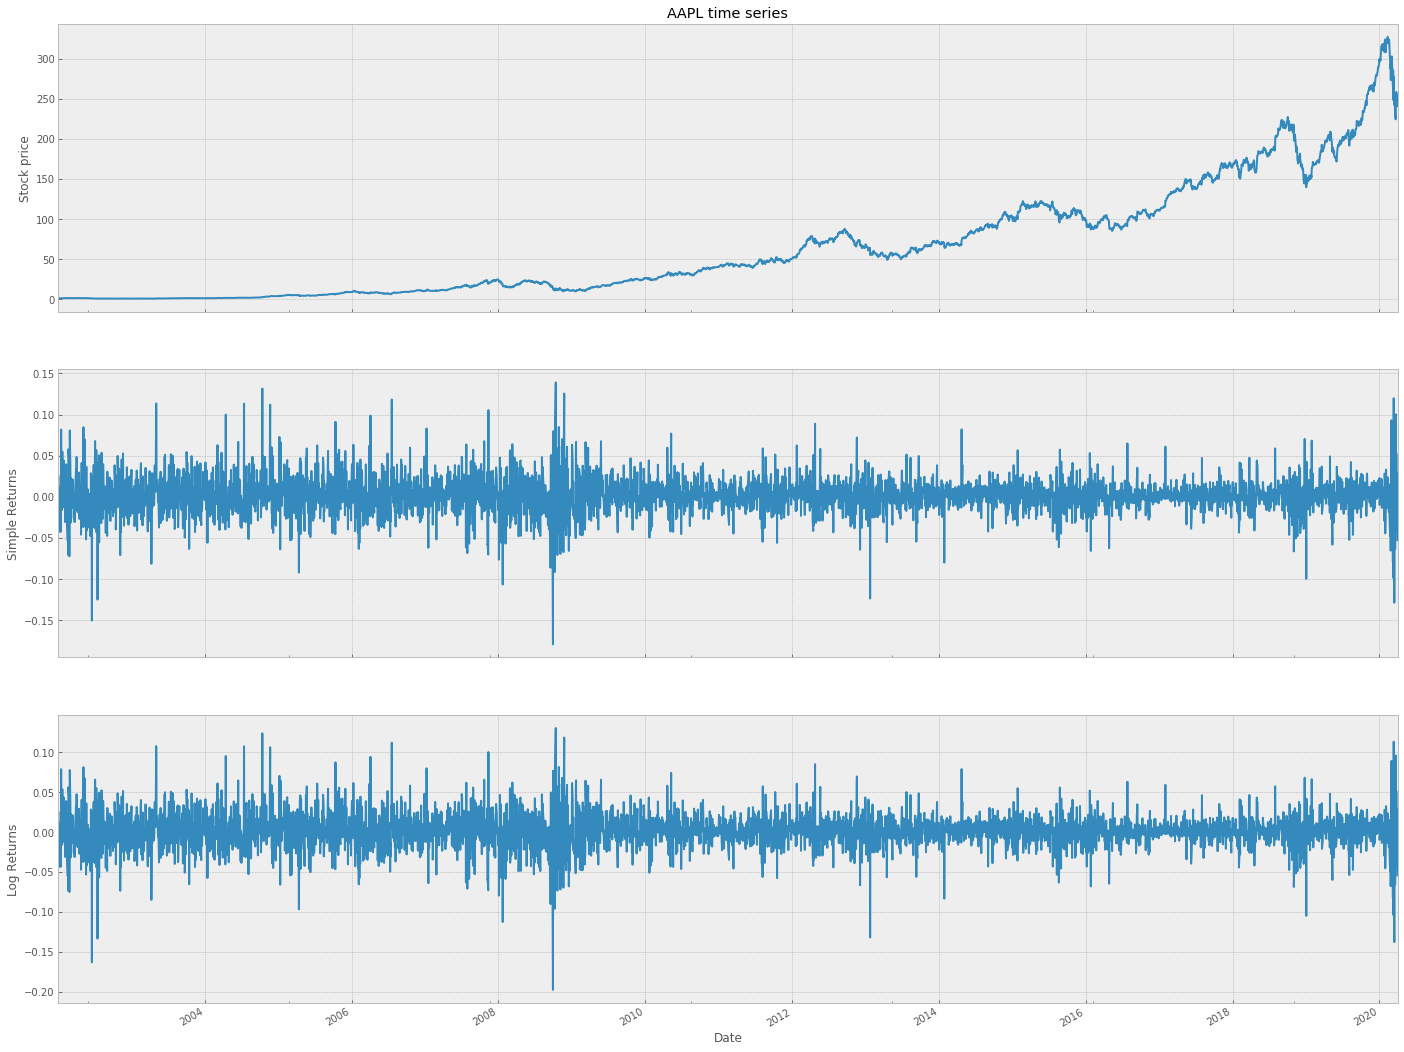

In [321]:
fig, ax = plt.subplots(3, 1, figsize=(24,20), sharex=True)
df.adj_close.plot(ax=ax[0])
ax[0].set_title('AAPL time series')
ax[0].set_ylabel('Stock price')
ax[0].grid(True)
df.simple_rtn.plot(ax=ax[1])
ax[1].set_ylabel('Simple Returns')
ax[1].grid(True)
df.log_rtn.plot(ax=ax[2])
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Log Returns')
ax[2].grid(True)
plt.style.use('bmh')

In [306]:
#rolling mean and std dev
df_rolling= df[['simple_rtn']].rolling(window=50).agg(['mean', 'std'])
df_rolling

simple_rtn          
                 mean       std
Date                           
2002-01-02        NaN       NaN
2002-01-03        NaN       NaN
2002-01-04        NaN       NaN
2002-01-07        NaN       NaN
2002-01-08        NaN       NaN
...               ...       ...
2020-03-26  -0.002737  0.045543
2020-03-27  -0.003479  0.045870
2020-03-30  -0.003159  0.046040
2020-03-31  -0.003421  0.045994
2020-04-01  -0.004338  0.046517

[4594 rows x 2 columns]

In [307]:
df_rolling.columns = df_rolling.columns.droplevel()

In [308]:
# detect outliers
df_outliers = df.join(df_rolling)
def identify_outliers(row, n_sigmas=3):
    x=row['simple_rtn']
    mu=row['mean']
    sigma=row['std']
    if (x > mu + 2.5 * sigma) or (x < mu - 2.5 * sigma):
        return 1
    else:
        return 0

In [309]:
# it automatically aplies our function, no need to define more
df_outliers['outlier'] = df_outliers.apply(identify_outliers, axis=1)

In [310]:
outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]

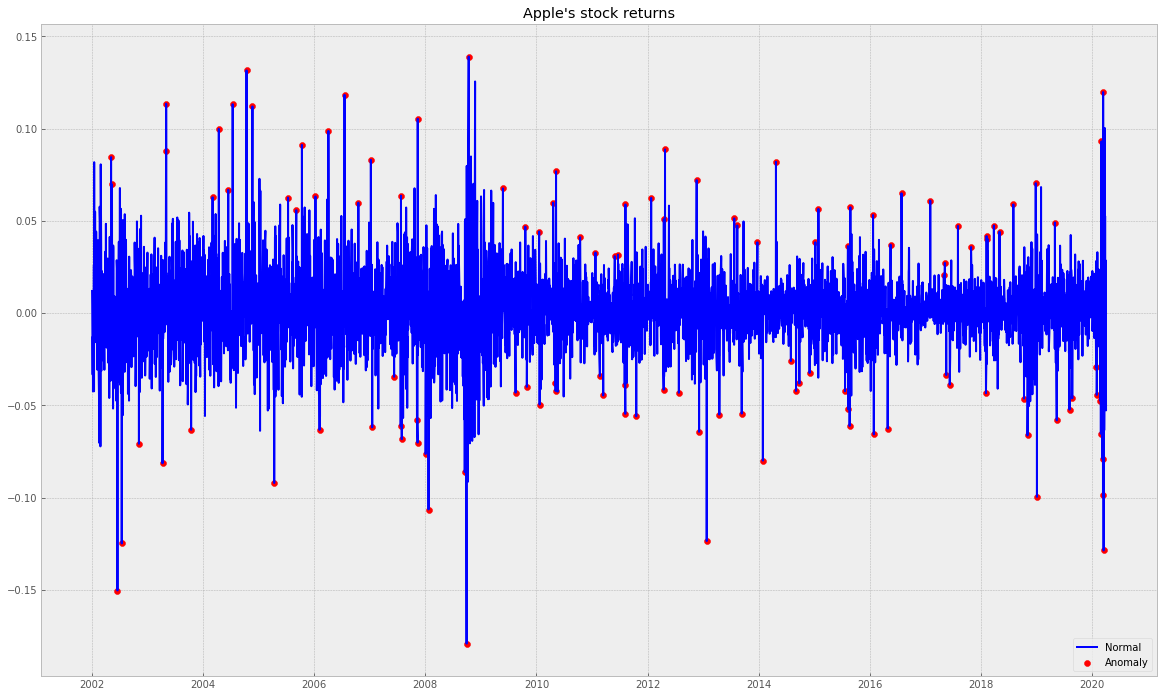

In [322]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(df_outliers.index, df_outliers.simple_rtn, color ='blue', label= 'Normal')
ax.scatter(outliers.index, outliers.simple_rtn, color='red', label='Anomaly')
ax.set_title("Apple's stock returns")
ax.legend(loc='lower right')
ax.grid(True)
plt.style.use('bmh')

In [323]:
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [324]:
r_range = np.linspace(min(df.log_rtn[1:]), max(df.log_rtn[1:]), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

Text(0.5, 1.0, 'Q-Q plot')

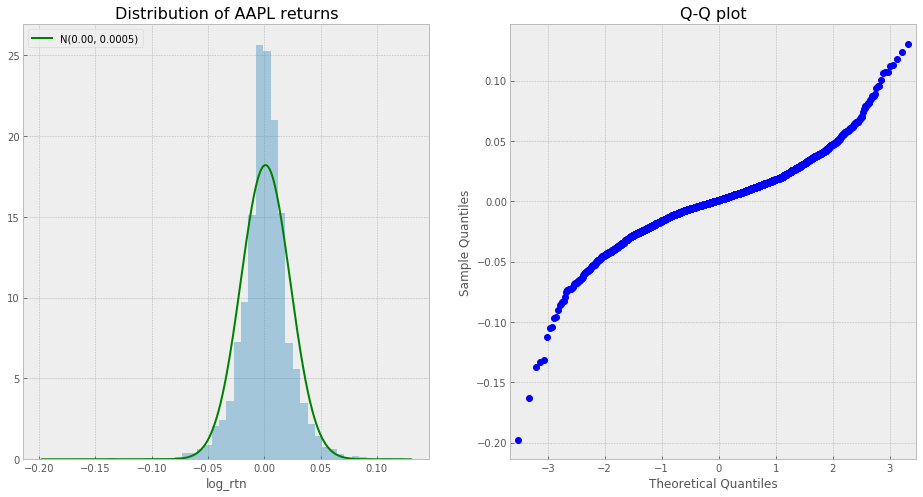

In [362]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# histogram
sns.distplot(df.log_rtn[1:], kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of AAPL returns', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');
# Q-Q plot
import pylab as py 
qq = sm.qqplot(df.log_rtn.values, line = 's', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)
# negative skewness and excess kurtosis

In [326]:
# Absence of autocorrelation in returns
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05 #define parameters to create autocorrelation plots
df.log_rtn.dropna(inplace=True)

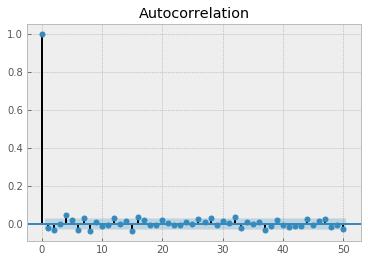

In [351]:
acf = smt.graphics.plot_acf(df.log_rtn, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
#  We can assume that we have verified
# that there is no autocorrelation in the log returns series.

[Text(0, 0.5, 'Absolute Returns'), Text(0.5, 0, 'Lag')]

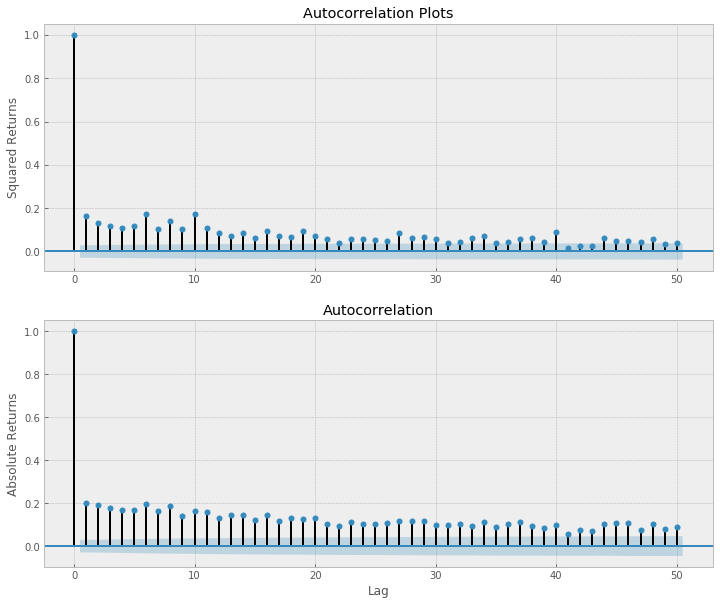

In [347]:
# Investigate this fourth fact by creating the ACF plots of squared and absolute returns.
fig, ax = plt.subplots(2,1, figsize=(12,10))
smt.graphics.plot_acf(df.log_rtn**2, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title='Autocorrelation Plots', ylabel='Squared Returns')
smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel='Absolute Returns', xlabel='Lag')

In [353]:
# LEVERAGE EFFECT
df['moving_std_252'] = df[['log_rtn']].rolling(252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(21).std()

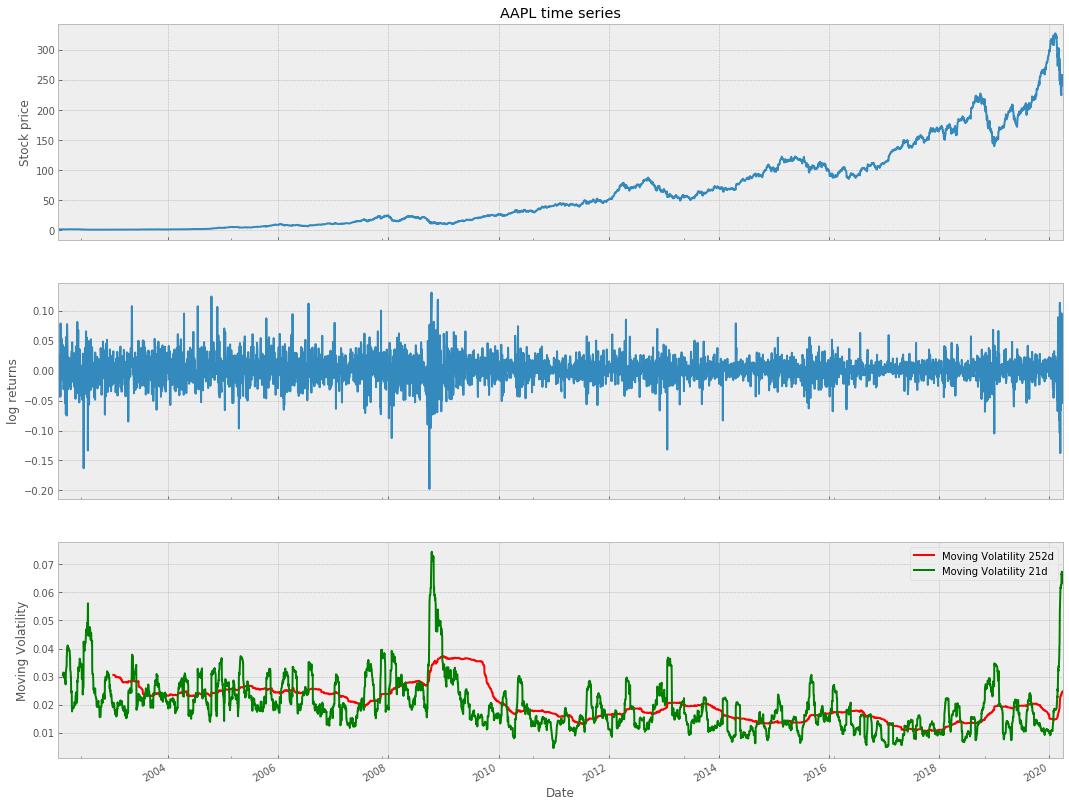

In [355]:
fig, ax = plt.subplots(3,1, figsize=(18,15), sharex=True)
df.adj_close.plot(ax=ax[0])
ax[0].set(title='AAPL time series', ylabel='Stock price')
df.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel='log returns')
df.moving_std_252.plot(ax=ax[2], color='r', label='Moving Volatility 252d')
df.moving_std_21.plot(ax=ax[2], color='g', label= 'Moving Volatility 21d')
ax[2].set(ylabel='Moving Volatility', xlabel='Date')
ax[2].legend()